In [1]:
# prepare train label
label_list = {}
label_file_path = 'label_2.tsv'
label_file = open(label_file_path)

#if there is header
next(label_file)
for line in label_file:
    qid, pid, label = line.strip().split("\t")
    label_list[qid, pid] = label

print('Loading label finished')
#print(label_list)

Loading label finished


In [2]:
# prepare feature data
import pandas as pd
feature = pd.read_csv('feature.tsv', sep = '\t')
#feature.drop(columns = '')
print('Loading feature finished')

Loading feature finished


In [3]:
# make pairs for training
from itertools import combinations
def make_pairs(file_path, query_num, passage_num):

    ## collect passages
    qp = {}

    file = open(file_path)
    next(file)
    for line in file:
        #qid, pid, query, passage = line.strip().split("\t")
        qid, pid1, pid2 = line.strip().split("\t")
        if (qid not in qp) & (len(qp) < query_num):
            qp[qid] = [pid1]
            qp[qid].append(pid2)
            
        # collect specific passage
        elif (qid in qp) & (len(qp[qid]) < passage_num):
            if pid1 not in qp[qid]:
                qp[qid].append(pid1)
            if pid2 not in qp[qid]:
                qp[qid].append(pid2)
        elif (len(qp) == query_num) & (len(qp[qid]) == passage_num):
            break
        
        """collect all passages 
        else:
            qp[qid].append(pid)"""


    # all combination
    comb_list = {}
    
    for q in qp.keys():
        comb_list[q] = list(combinations(qp[q], 2))
    #print(comb_list)
    
    
    # make it as array
    comb_array = []
    for i, k in enumerate(comb_list.keys()):
        for i, j in enumerate(comb_list[k]):
        #print(k, j[0], j[1])
            comb_array.append([k, j[0], j[1]])
    
    return comb_array


In [17]:
array = make_pairs('triple_test.tsv', 6000, 10)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(200)), Input(shape=(200))]
        return Model(inputs=x, outputs=self.call(x))

In [6]:

def get_label(label_data, qid, pid):
    if (qid, pid) in label_data:
        return 1
    else:
        return 0

In [18]:
len(array)

269373

In [19]:
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []





for line in array:
    qid = line[0]
    pid1 = line[1]
    pid2 = line[2]
        
    xi.append(list(np.float_(feature.loc[feature.pid == int(pid1),'passage'].values[0].strip('][').split(', '))))
        #list(np.float_(feature.loc[feature.pid == 1811 ,'Feature_Vector'].values[0].strip('][').split(', ')))
    xj.append(list(np.float_(feature.loc[feature.pid == int(pid2),'passage'].values[0].strip('][').split(', '))))
    pair_id.append([pid1, pid2])
    pair_query_id.append(qid)
    
    
    label_data = label_list
    label_pid1 = get_label(label_data, qid, pid1)
    label_pid2 = get_label(label_data, qid, pid2)
    
    if label_pid1 == label_pid2:
        _pij = 0.5
    elif label_pid1 > label_pid2:
        _pij = 1
    else: 
         _pij = 0
    pij.append(_pij)

        



xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

print('Prepare data finished')

Prepare data finished


In [20]:
# split data
xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test= train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)

# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs = 10, validation_data=([xi_test, xj_test], pij_test))



Epoch 1/10
6735/6735 [==============================] - 4s 542us/step - loss: 0.7020 - val_loss: 0.6894
Epoch 2/10
6735/6735 [==============================] - 3s 483us/step - loss: 0.6879 - val_loss: 0.6873
Epoch 3/10
6735/6735 [==============================] - 3s 473us/step - loss: 0.6849 - val_loss: 0.6850
Epoch 4/10
6735/6735 [==============================] - 3s 481us/step - loss: 0.6826 - val_loss: 0.6836
Epoch 5/10
6735/6735 [==============================] - 3s 486us/step - loss: 0.6809 - val_loss: 0.6822
Epoch 6/10
6735/6735 [==============================] - 3s 485us/step - loss: 0.6793 - val_loss: 0.6810
Epoch 7/10
6735/6735 [==============================] - 3s 485us/step - loss: 0.6781 - val_loss: 0.6799
Epoch 8/10
6735/6735 [==============================] - 3s 484us/step - loss: 0.6766 - val_loss: 0.6797
Epoch 9/10
6735/6735 [==============================] - 3s 485us/step - loss: 0.6757 - val_loss: 0.6781
Epoch 10/10
6735/6735 [==============================] - 3s 484u

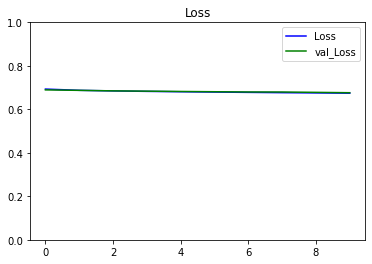

In [21]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)


In [22]:
from itertools import combinations
def make_pairs_test(file_path, query_num):

    ## collect passages
    qp = {}

    file = open(file_path)
    next(file)
    for line in file:
        #qid, pid, query, passage = line.strip().split("\t")
        qid, pid1, pid2 = line.strip().split("\t")
        if (qid not in qp) & (len(qp) < query_num):
            qp[qid] = [pid1]
            qp[qid].append(pid2)
            
        # collect all passage
        elif qid in qp:
            if pid1 not in qp[qid]:
                qp[qid].append(pid1)
            if pid2 not in qp[qid]:
                qp[qid].append(pid2)

        else:
            break


    # all combination
    comb_list = {}
    
    for q in qp.keys():
        comb_list[q] = list(combinations(qp[q], 2))
    #print(comb_list)
    
    
    # make it as array
    comb_array = []
    for i, k in enumerate(comb_list.keys()):
        for i, j in enumerate(comb_list[k]):
        #print(k, j[0], j[1])
            comb_array.append([k, j[0], j[1]])
    
    return comb_array


In [23]:
test = make_pairs_test('test_query.tsv', 1)

In [24]:
xi_eval = []
xj_eval = []
for item in test:
    xi_eval.append(list(np.float_(feature.loc[feature.pid == int(item[1]),'passage'].values[0].strip('][').split(', '))))
    xj_eval.append(list(np.float_(feature.loc[feature.pid == int(item[2]),'passage'].values[0].strip('][').split(', '))))

xi_eval = np.array(xi_eval)
xj_eval = np.array(xj_eval)

In [25]:
predict = ranknet.predict([xi_eval, xj_eval])

In [26]:
predict

array([[0.47286198],
       [0.49877295],
       [0.5001353 ],
       ...,
       [0.4957099 ],
       [0.50618535],
       [0.5104744 ]], dtype=float32)

In [27]:
len(predict)

499500

In [ ]:
test

In [28]:
# create ranking based on probability
qp_rank = []
#pair_id_eval


index = 0
for p in predict:
    qp_rank.append([test[index][0], test[index][1], float(p)])
    qp_rank.append([test[index][0], test[index][2], 1-float(p)])
    
    #print(index)
    index += 1

score_board = pd.DataFrame(qp_rank, columns=[
    "qid", "pid", "score"]).groupby(['qid', 'pid']).agg({"score": "sum"}).sort_values(['qid','score'], ascending=False).reset_index()
print(score_board.shape)
print(score_board.head())

(1000, 3)
       qid      pid       score
0  1006748  7982952  928.788690
1  1006748  5103082  890.241892
2  1006748  5103083  865.835593
3  1006748  5637948  828.798747
4  1006748  8068340  799.752721


In [29]:
score_board

,qid,pid,score
0,1006748,7982952,928.788690
1,1006748,5103082,890.241892
2,1006748,5103083,865.835593
3,1006748,5637948,828.798747
4,1006748,8068340,799.752721
...,...,...,...
995,1006748,4577288,377.148542
996,1006748,4251222,374.390625
997,1006748,7273705,365.039765
998,1006748,5443938,361.183752


In [32]:
score_board.to_csv('score.tsv', sep = '\t', header = True, index = False)

In [34]:
score_board[score_board['pid'] == '3543528']

,qid,pid,score
674,1006748,3543528,487.983704


In [35]:
score_lines = score_board[['qid', 'pid']].to_numpy()

In [36]:
rank_score ={}
for p in score_lines:
    #print(p)
    if p[0] not in rank_score:
        rank_score[p[0]] = []
    
    if (p[0], p[1]) in label_list:
        rank_score[p[0]].append(1)
        #print(p[0], p[1])
    else:
        rank_score[p[0]].append(0)

    

In [38]:
# precision rate per pair
count = 0
index = 0
for p in test:
    if ((p[0], p[1]) in label_list) & (predict[index] > 0.5):
        #print(p)
        count += 1
    elif ((p[0], p[2]) in label_list) & (predict[index] < 0.5):
        #print(p)
        count += 1
    elif ((p[0], p[1]) not in label_list) & ((p[0], p[2]) not in label_list)& (predict[index] == 0.5):
        #print(p)
        count += 1
    
    index +=1
print(count/1000)

0.325
